In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
import numpy as np
from scipy.special import logit, expit
from scipy.stats import norm
from tqdm.notebook import tqdm

#**Dual Representations**

Loss Function

$J(w) = \frac{1}{2} \sum_{n=1}^{N} (w^T \phi(x_n) - t_n)^2 + \frac{\lambda}{2}w^T w$

Zero derivative solution:

$k(x, x') = \phi(x)^T \phi(x')$

$K_{m n} = k(x_m, x_n)$

$y_{pred} = k(x)^T (K + \lambda I_N)^{-1}t$

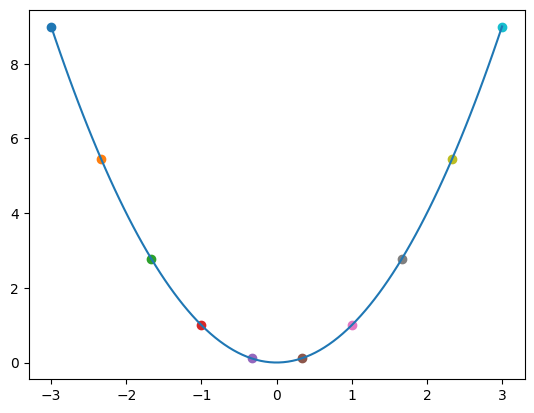

In [ ]:
def targetFunc(x):
  return x ** 2

x_train = np.linspace(-3, 3, 100) # 100
y_train = targetFunc(x_train)    # 100
plt.plot(x_train, y_train)

def getPhi(x):
  return np.array([[1.0], [x], [x**2]]) # 3 * 1

K = np.ones((100, 100))  # 100 * 100
for i in range(0, 100):
  for j in range(0, 100):
    K[i][j] = getPhi(x_train[i]).T @ getPhi(x_train[j]) # 1 * 1 each

lambda_ = 1

x_test = np.linspace(-3, 3, 10)
for i in range(0, 10):
  x = x_test[i]
  phi = getPhi(x)
  k = np.ones((100, 1))
  for j in range(0, 100):
    k[j][0] = getPhi(x_test[i]).T @ getPhi(x_train[j])
  y = k.T @ inv(K + lambda_ * np.eye(100)) @ y_train[:, np.newaxis]  # 100 * 1
  plt.scatter(x, y)

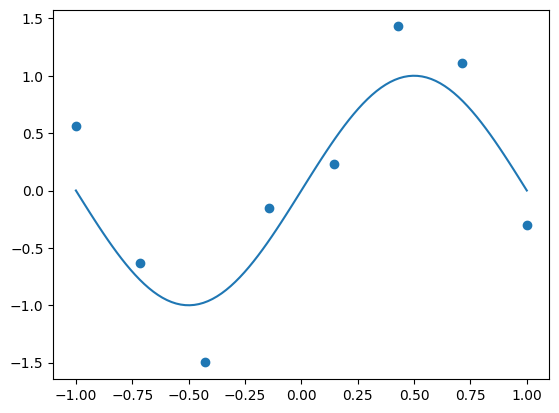

In [ ]:
def targetFunc(x):
  return np.sin(np.pi * x)

def targetData(x):
  return targetFunc(x) + np.random.normal(0.0, 0.3, x.shape)

x_func = np.linspace(-1, 1, 100)
y_func = targetFunc(x_func)
plt.plot(x_func, y_func)

train_size = 8
x_train = np.linspace(-1, 1, 8)
y_train = targetData(x_train)
plt.scatter(x_train, y_train)

In [ ]:
def predict(x, X, t, sigma):
    g = norm.pdf(x - X[:, np.newaxis], loc=0, scale=sigma).T
    k = g / g.sum(axis=1, keepdims=True)

    # Conditional Expectation  E[t|x]
    Et = (k * t[np.newaxis, :]).sum(axis=1)
    # Conditional Variance V[t|x]
    Vt = sigma ** 2 + (k * t[np.newaxis, : ] ** 2).sum(axis=1) - Et ** 2
    return Et, Vt

Text(0.5, 0.98, 'Isotropic Kernel Regression')

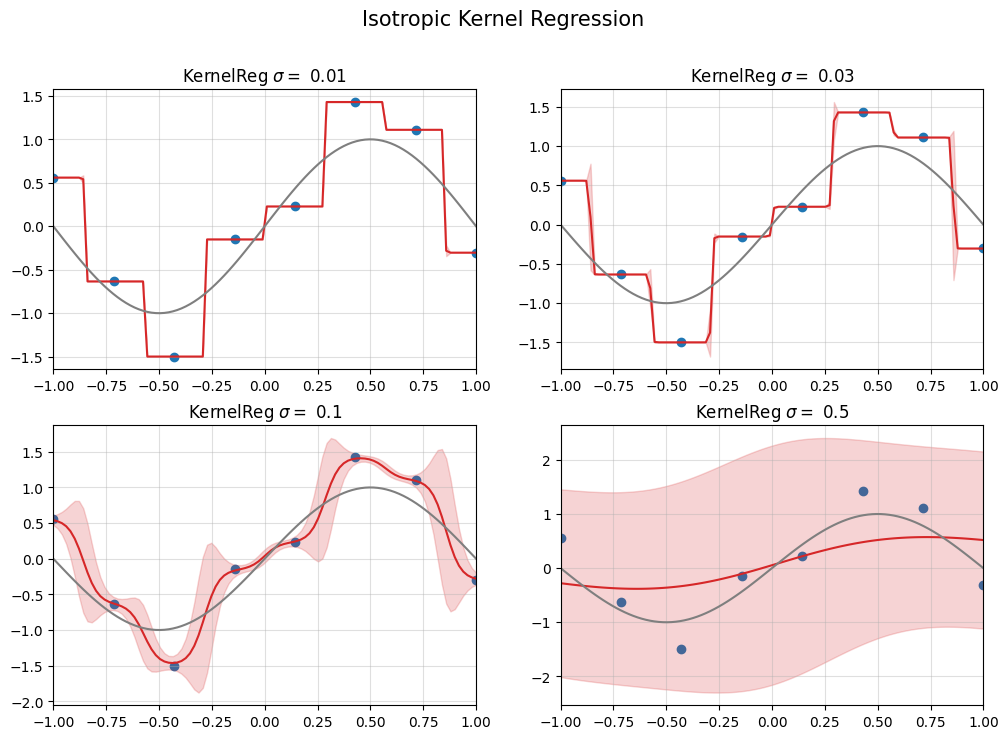

In [ ]:
sigma=0.09
ntest = 100
x = np.linspace(-1, 1, ntest)

sigmas = [0.01, 0.03, 0.1, 0.5]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for sigma, axi in zip(sigmas, ax.ravel()):
    Et, Vt = predict(x, x_train, y_train, sigma)
    axi.scatter(x_train, y_train)
    axi.plot(x, Et, color="tab:red")
    axi.fill_between(x, Et - 2 * Vt, Et + 2 * Vt, alpha=0.2, color="tab:red")
    axi.plot(x_func, y_func, c="tab:gray")
    axi.grid(alpha=0.4)
    axi.set_title("KernelReg " r"$\sigma=$ " f"{sigma}")
    axi.set_xlim(-1, 1);
plt.suptitle("Isotropic Kernel Regression", fontsize=15)

#**Gaussian processes for regression**

$p(\mathbf{t} | \mathbf{y}) = \mathcal{N}(\mathbf{t} | \mathbf{y}, \beta^{-1}I)$

By the property of linear regression in (305), we get:

$p(\mathbf{y}) = \mathcal{N}(\mathbf{y} | 0, \mathbf{K})$ (K should imply the relationship the similarity between x and the similarity between y(x))

In the example below, I used the kernel:

$k(x_n, x_m) = \theta_0 exp(\frac{\theta_1}{2}||x_n-x_m||^2) + \theta_2 + \theta_3 x_n^T x_m$

(I set $\theta_2$ and $\theta_3$ to $0$ for simplicity)

\\
Training:

$p(\mathbf{t}_{N+1}) = \mathcal{N}(\mathbf{t}_{N+1} | 0, \mathbf{C}_{N+1})$

$\mathbf{C}_{N+1} = \begin{bmatrix}
    \mathbf{C}_{N}       & k(x_n, x_{N+1}) \\
    k(x_n, x_{N+1})^T       & c \\
\end{bmatrix}$

$c = k(x_{N+1}, x_{N+1}) + \beta^{-1}$

\\
Prediction:

$m(x_{N+1}) = \mathbf{k}^T \mathbf{C}^{-1}_N\mathbf{t}$

$\sigma^2(x_{N+1}) = c - \mathbf{k}^T \mathbf{C}^{-1}_N\mathbf{k}$

(we know the mean of $\mathbf{t}_n$ and $\mathbf{t}_{N+1}$ as well as their covariance $\mathbf{C}_{N+1}$. Thus we can calculate $p(\mathbf{t}_{N+1} | \mathbf{t}_n)$)

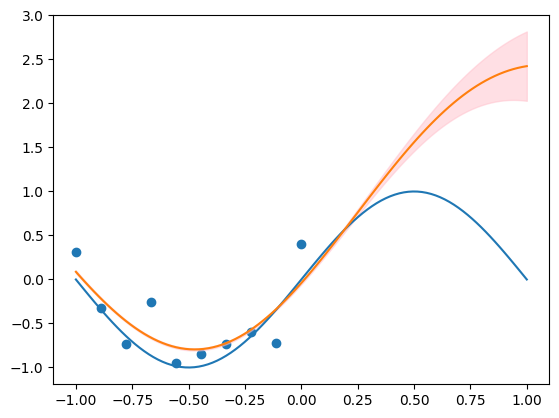

In [ ]:
def targetFunc(x):
  return np.sin(np.pi * x)

def targetData(x):
  return targetFunc(x) + np.random.normal(0.0, 0.3, x.shape)

x_func = np.linspace(-1, 1, 100)
y_func = targetFunc(x_func)
plt.plot(x_func, y_func)

train_size = 10
x_train = np.linspace(-1, 0, train_size)  # no data from 0 to 1
# x_train = np.concatenate((np.linspace(-1, 0, train_size // 5 * 4), np.linspace(0, 1, train_size // 5 * 1))) # less data from 0 to 1

y_train = targetData(x_train)
plt.scatter(x_train, y_train)



# train
beta = 100
theta0 = 1
theta1 = 1
# make the K so that we can calculate C easier
K = theta0 * np.exp(- theta1/2 * (x_train[:, np.newaxis] - x_train[np.newaxis, :]) ** 2)
C = np.array([[K[0][0] + 1/beta]])
for i in range(1, train_size):
  x_N_1 = x_train[i]
  x_n = x_train[:i]
  k = theta0 * np.exp(- theta1/2 * (x_n-x_N_1) ** 2)

  # update C
  C = np.concatenate((C, k[np.newaxis, :]), axis = 0)

  k = np.append(k, K[i][i] + 1/beta)    # append c
  C = np.concatenate((C, k[:, np.newaxis]), axis = 1)


x_test = np.linspace(-1, 1, 100)
m_s = []
var_s = []
for i in range(0, 100):
  k = theta0 * np.exp(- theta1/2 * (x_train - x_test[i])**2)
  c = theta0 * np.exp(- theta1/2 * (x_test[i] - x_test[i])**2) + 1/beta
  m = k.T @ inv(C) @ y_train
  var = c - k.T @ inv(C) @ k
  m_s.append(m)
  var_s.append(var)

m_s = np.array(m_s)
var_s = np.array(var_s)

plt.plot(x_test, m_s)
plt.fill_between(x_test, m_s - var_s, m_s + var_s, alpha=0.5, color="pink", label="std")

#**Learning the Hyperparameters**

Here I set $\theta_0$ and $\theta_1$ initially be 0.1

\\
Use maximum likelihood to update $\theta$

$ln(p(\mathbf{t}|\theta)) = -\frac{1}{2}ln|\mathbf{C}_N| - \frac{1}{2}\mathbf{t}^T\mathbf{C}^{-1}\mathbf{t} - \frac{N}{2}ln(2\pi)$

$\frac{\delta}{\delta\theta_i}ln(p(\mathbf{t}|\theta_i)) = -\frac{1}{2}Tr(\mathbf{C}_N^{-1}\frac{\delta \mathbf{C}_N}{\delta\theta_i}) + \frac{1}{2}\mathbf{t}^T\mathbf{C}_N^{-1}\frac{\delta \mathbf{C}_N}{\delta\theta_i}\mathbf{C}_N^{-1}\mathbf{t}$

\\
Here I calculated the derivatives myself:

$\frac{\delta \mathbf{C}_N}{\delta\theta_0} = exp(\frac{\theta_1}{2}||x_n-x_m||^2)$

$\frac{\delta \mathbf{C}_N}{\delta\theta_1} = \frac{1}{2} ||x_n-x_m||^2 \theta_0 exp(\frac{\theta_1}{2}||x_n-x_m||^2)$

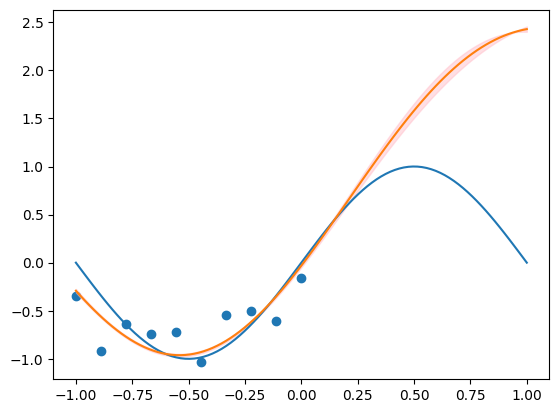

In [ ]:
def targetFunc(x):
  return np.sin(np.pi * x)

def targetData(x):
  return targetFunc(x) + np.random.normal(0.0, 0.3, x.shape)


train_size = 10
x_train = np.linspace(-1, 0, train_size)  # no data from 0 to 1
# x_train = np.concatenate((np.linspace(-1, 0, train_size // 5 * 4), np.linspace(0, 1, train_size // 5 * 1))) # less data from 0 to 1
y_train = targetData(x_train)



# train
beta = 100
theta0 = 0.1
theta1 = 0.1

iters = 50
for iter in range(0, iters):
  # make the K so that we can calculate C easier
  K = theta0 * np.exp(- theta1/2 * (x_train[:, np.newaxis] - x_train[np.newaxis, :]) ** 2)
  C = np.array([[K[0][0] + 1/beta]])
  for i in range(1, train_size):
    x_N_1 = x_train[i]
    x_n = x_train[:i]
    k = theta0 * np.exp(- theta1/2 * (x_n-x_N_1) ** 2)

    # update C
    C = np.concatenate((C, k[np.newaxis, :]), axis = 0)

    k = np.append(k, K[i][i] + 1/beta)    # append c
    C = np.concatenate((C, k[:, np.newaxis]), axis = 1)

  # update hyperparameters
  dCN_dtheta0 = C / theta0
  half_square_difference = np.log(C / theta0) / theta1
  dCN_dtheta1 = half_square_difference * C

  grad_theta0 = -0.5 * np.trace(inv(C) @ dCN_dtheta0) + 0.5 * y_train.T @ inv(C) @ dCN_dtheta0 @ inv(C) @ y_train
  grad_theta1 = -0.5 * np.trace(inv(C) @ dCN_dtheta1) + 0.5 * y_train.T @ inv(C) @ dCN_dtheta1 @ inv(C) @ y_train
  theta0 -= 0.0001 * grad_theta0
  theta1 -= 0.0001 * grad_theta1
  # print(grad_theta0)
  # print(grad_theta1)



# target graph
x_func = np.linspace(-1, 1, 100)
y_func = targetFunc(x_func)
plt.plot(x_func, y_func)
plt.scatter(x_train, y_train)

# our graph
x_test = np.linspace(-1, 1, 100)
m_s = []
var_s = []
for i in range(0, 100):
  k = theta0 * np.exp(- theta1/2 * (x_train - x_test[i])**2)
  c = theta0 * np.exp(- theta1/2 * (x_test[i] - x_test[i])**2) + 1/beta
  m = k.T @ inv(C) @ y_train
  var = c - k.T @ inv(C) @ k
  m_s.append(m)
  var_s.append(var)

m_s = np.array(m_s)
var_s = np.array(var_s)

plt.plot(x_test, m_s)
plt.fill_between(x_test, m_s - var_s, m_s + var_s, alpha=0.5, color="pink", label="std")

#**Automatic relevance determination**

Just replace $\theta_1$ with multiple parameters, each corresponding to one training data.

#**Gaussian processes for classification**

Suppose we are predicting an activant $a$, then we can apply the same result:

$p(\mathbf{a}_{N+1}) = \mathcal{N}(\mathbf{a}_{N+1} | 0, \mathbf{C}_{N+1})$

$C(x_n, x_m) = k(x_n, x_m) + νδ_{nm}$

(Simply replace $\frac{1}{\beta}$ with $ν$)

\\
Training

$a^{new}_N = C_N (I + W_N C_N ) ^ {−1} \{t_N - σ_N + W_N a_N \} $

\\
Predicting

$E[a_{N+1}|t_N ] = k^T(t_N - σ_N )$

$var[a_{N+1}|t_N ] = c - k^T(W^{−1}_N + C_N )^{−1}k$

\\
Remember to add sigmoid on $a_{N+1}$ for testing.

<ipython-input-31-aadcf50fb444>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)[:, None]


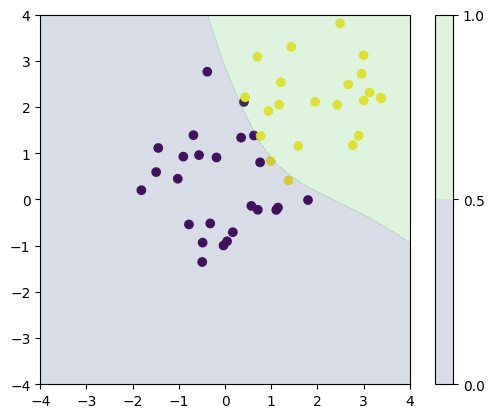

In [ ]:
def sigmoid(x):
  return 1.0 / (1.0 + np.e ** (-x))

x_train = np.concatenate([np.random.normal(size=50).reshape(-1, 2), np.random.normal(size=50).reshape(-1, 2) + 2.], axis=0)
y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)[:, None]
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())

# train
v = 0.01
theta0 = 1
theta1 = 1

K = theta0 * np.exp(- theta1/2 * ((x_train[:, np.newaxis] - x_train[np.newaxis, :]) ** 2).sum(2))
C = K + np.eye(K.shape[0]) * v

iters = 10000
a_N = np.random.multivariate_normal(np.zeros_like(C[0]), C)[:, np.newaxis]  # N * 1
sigma_N = None
W_N = None
for iter in range(0, iters):
  sigma_N = sigmoid(a_N)    # N * 1
  W_N = sigmoid(a_N) * (1 - sigmoid(a_N)) * np.eye(a_N.shape[0])  # N * N
  a_N = C @ inv(np.eye(C.shape[0]) + W_N @ C) @ (y_train - sigma_N + W_N @ a_N) # N * 1
  # a_N -= inv((-W_N - inv(C))) @ (y_train - sigma_N - inv(C) @ a_N)
  # a_N = C @ (y_train - sigma_N)



test_size = 50
x0, x1 = np.meshgrid(np.linspace(-4, 4, test_size), np.linspace(-4, 4, test_size))
x_test = np.array([x0, x1]).reshape(2, -1).T

m_s = []
var_s = []
for i in range(0, test_size * test_size):
  k = theta0 * np.exp(- theta1/2 * ((x_train - x_test[i])**2).sum(1))[:, np.newaxis]
  c = theta0 * np.exp(- theta1/2 * ((x_test[i] - x_test[i])**2).sum(0)) + v
  m = k.T @ (y_train - sigma_N)
  var = c - k.T @ inv(inv(W_N) + C) @ k
  m_s.append(m[0][0])
  var_s.append(var)

m_s = np.array(m_s)
m_s = sigmoid(m_s)
# print(m_s)
var_s = np.array(var_s)
plt.contourf(x0, x1, m_s.reshape(test_size, test_size), levels=np.linspace(0,1,3), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')

#**Learning the Hyperparameters**

Simply use (6.91)

<ipython-input-43-67a00e5397fa>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)[:, None]
<ipython-input-43-67a00e5397fa>:2: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + np.e ** (-x))


-4.295038198467155
-1.3600641270414906


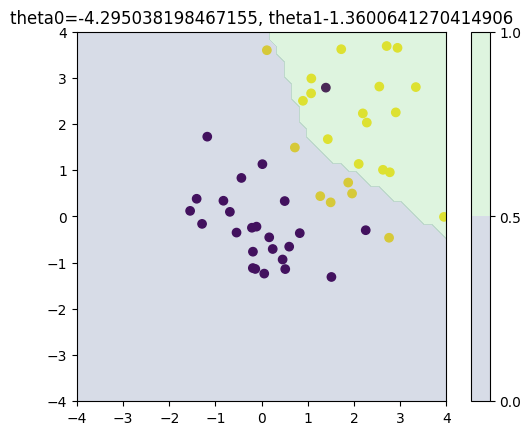

In [ ]:
def sigmoid(x):
  return 1.0 / (1.0 + np.e ** (-x))

x_train = np.concatenate([np.random.normal(size=50).reshape(-1, 2), np.random.normal(size=50).reshape(-1, 2) + 2.], axis=0)
y_train = np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)[:, None]
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())

# train
v = 0.01
theta0 = 0.1
theta1 = 0.1

K = theta0 * np.exp(- theta1/2 * ((x_train[:, np.newaxis] - x_train[np.newaxis, :]) ** 2).sum(2))
C = K + np.eye(K.shape[0]) * v

iters = 10000
a_N = np.random.multivariate_normal(np.zeros_like(C[0]), C)[:, np.newaxis]  # N * 1
sigma_N = None
W_N = None
for iter in range(0, iters):
  sigma_N = sigmoid(a_N)    # N * 1
  W_N = sigmoid(a_N) * (1 - sigmoid(a_N)) * np.eye(a_N.shape[0])  # N * N
  a_N = C @ inv(np.eye(C.shape[0]) + W_N @ C) @ (y_train - sigma_N + W_N @ a_N) # N * 1
  # a_N -= inv((-W_N - inv(C))) @ (y_train - sigma_N - inv(C) @ a_N)
  # a_N = C @ (y_train - sigma_N)

  # learn the hyperparameters
  if iter % 10 == 0:
    dCN_dtheta0 = K / theta0
    half_square_difference = - 1/2 * ((x_train[:, np.newaxis] - x_train[np.newaxis, :]) ** 2).sum(2)
    dCN_dtheta1 = half_square_difference * K

    grad_theta0 = 0.5 * a_N.T @ inv(C) @ dCN_dtheta0 @ inv(C) @ a_N - 0.5 * np.trace(inv(np.eye(C.shape[0]) + C @ W_N) @ W_N @ dCN_dtheta0)
    grad_theta1 = 0.5 * a_N.T @ inv(C) @ dCN_dtheta1 @ inv(C) @ a_N - 0.5 * np.trace(inv(np.eye(C.shape[0]) + C @ W_N) @ W_N @ dCN_dtheta1)
    theta0 -= 0.0001 * grad_theta0[0][0]
    theta1 -= 0.0001 * grad_theta1[0][0]
    # print(grad_theta0)
    # print(grad_theta1)


test_size = 50
x0, x1 = np.meshgrid(np.linspace(-4, 4, test_size), np.linspace(-4, 4, test_size))
x_test = np.array([x0, x1]).reshape(2, -1).T

m_s = []
var_s = []
for i in range(0, test_size * test_size):
  k = theta0 * np.exp(- theta1/2 * ((x_train - x_test[i])**2).sum(1))[:, np.newaxis]
  # print(k)
  c = theta0 * np.exp(- theta1/2 * ((x_test[i] - x_test[i])**2).sum(0)) + v
  # print(c)
  m = k.T @ (y_train - sigma_N)
  var = c - k.T @ inv(inv(W_N) + C) @ k
  m_s.append(m[0][0])
  var_s.append(var)

m_s = np.array(m_s)
m_s = sigmoid(m_s)
# print(m_s)
var_s = np.array(var_s)
plt.contourf(x0, x1, m_s.reshape(test_size, test_size), levels=np.linspace(0,1,3), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("theta0=" + str(theta0) + ", theta1=" + str(theta1))
print(theta0)
print(theta1)